In [114]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset

In [115]:
for module in np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

numpy 2.0.2
pandas 2.2.3
sklearn 1.5.2
torch 2.6.0+cu126
cuda:0


In [116]:
housing = fetch_california_housing(data_home="data")

print(housing.data.shape)
print(housing.target.shape)
print(type(housing.data))

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(f"x_train shape : {x_train.shape}")
print(f"x_valid shape : {x_valid.shape}")
print(f"x_test  shape : {x_test.shape}")

dataset_maps = {"train":[x_train, y_train],
                "valid":[x_valid, y_valid],
                "test" :[x_test, y_test]}

(20640, 8)
(20640,)
<class 'numpy.ndarray'>
x_train shape : (11610, 8)
x_valid shape : (3870, 8)
x_test  shape : (5160, 8)


In [117]:
scaler = StandardScaler()
scaler.fit(x_train)
print(torch.from_numpy(y_train).float())
print(len(torch.from_numpy(y_train).float().reshape(-1,1)))
print(torch.from_numpy(x_train).float().shape)


tensor([3.2260, 1.5140, 1.5980,  ..., 1.5000, 2.6360, 1.9250])
11610
torch.Size([11610, 8])


In [118]:
class HousingDataset(Dataset):
    def __init__(self, mode="train"):
        self.x, self.y = dataset_maps[mode]
        self.x = torch.from_numpy(scaler.transform(self.x)).float() # float方法将64bit转为torch.float32 提高兼容性
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1)    # 转为列向量


    def __len__(self):
        return len(self.x)


    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [119]:
train_ds = HousingDataset("train")
valid_ds = HousingDataset("valid")
test_ds  = HousingDataset("test")

batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [120]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )

    
    def forward(self, x):
        logits = self.linear_relu_stack(x)

        return logits

In [121]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience    = patience
        self.min_delta   = min_delta
        self.best_metric = -1
        self.count_step  = 0

    
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            self.best_metric = metric
            self.count_step = 0
        else:
            self.count_step += 1

    
    @property
    def early_stop(self):
        return self.count_step >= self.patience

In [122]:
@torch.no_grad()
def evaluating(model, dataloader, loss_function):
    loss_list = []

    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        logits = model(datas)
        loss = loss_function(logits, labels)
        loss_list.append(loss.item())

    return np.mean(loss_list)

In [123]:
def training_base(model,
                  train_dataloader,
                  valid_dataloader,
                  epoch,
                  loss_function,
                  optimizer,
                  early_stop_cb=None,
                  eval_step=500):
    record_dict={"train":[], "valid":[]}
    global_step = 0
    model.train()
    with tqdm(total = epoch * len(train_dataloader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_dataloader:
                datas = datas.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                logits = model(datas)
                loss = loss_function(logits, labels)
                loss.backward()
                optimizer.step()
                loss = loss.cpu().item()
                record_dict["train"].append({"loss":loss, "step":global_step})

                if global_step % eval_step == 0:
                    model.eval()
                    valid_loss = evaluating(model, valid_dataloader, loss_function)
                    record_dict["valid"].append({"loss":valid_loss, "step":global_step})
                    model.train()

                    if early_stop_cb is not None:
                        early_stop_cb(-valid_loss)  # 最小化损失loss => 最大化性能指标acc
                        if early_stop_cb.early_stop:
                            print(f"Early stop at epoch : {epoch_id}, global_step : {global_step}")
                            return record_dict
            
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch":epoch_id})
    return record_dict

In [124]:
model = NeuralNetwork()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
early_stop_cb = EarlyStopCallback(patience=10, min_delta=1e-3)
model = model.to(device)
epoch = 100
record = training_base(model, train_dataloader, valid_dataloader, epoch, loss_function, optimizer, early_stop_cb, eval_step=len(train_dataloader))

  0%|          | 0/36300 [00:00<?, ?it/s]

Early stop at epoch : 66, global_step : 23958


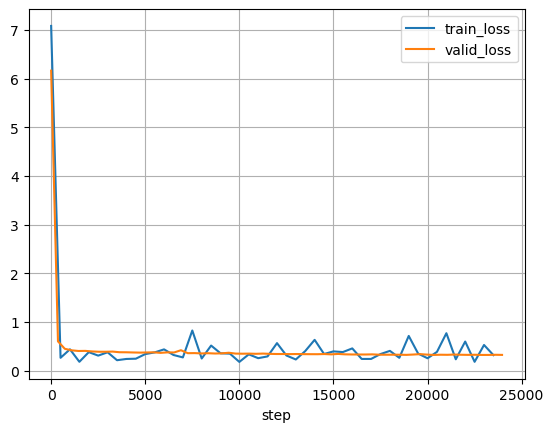

In [125]:
def plot_learning_curves(record_dict, sample_step=500):
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["valid"]).set_index("step")

    for idx, item in enumerate(train_df.columns):
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")
        plt.plot(val_df.index, val_df[item], label=f"valid_{item}")
        plt.grid()
        plt.legend()
        plt.xlabel("step")

        plt.show()

plot_learning_curves(record)

In [126]:
model.eval()
print(f"loss : {evaluating(model, test_dataloader, loss_function):.4f}")

loss : 0.3333
